# Visual-language assistant with Video-LLaVA and OpenVINO

Video-LLaVA (Learning United Visual Representation by Alignment Before Projection, [paper](https://arxiv.org/pdf/2311.10122.pdf)) is a Large Vision-Language Model (LVLM) that breaks new ground by understanding both images and videos through a single, unified visual representation. While LLaVA excels at image-based tasks, Video-LLaVA expands this fluency to the dynamic world of videos, enabling seamless comprehension and reasoning across both visual domains. This means it can answer questions, generate text, and perform other tasks with equal ease, regardless of whether it's presented with a still image or a moving scene.

In this tutorial we consider how to use Video-LLaVA model to build multimodal chatbot. For demonstration purposes we will use [Video-LLaVA-7B](https://huggingface.co/LanguageBind/Video-LLaVA-7B) model for conversion.

The tutorial consists from following steps:

- Install prerequisites
- Prepare input processor and tokenizer
- Download original model
- Compress model weights to 4 and 8 bits using NNCF
- Convert model to OpenVINO Intermediate Representation (IR) format
- Prepare OpenVINO-based inference pipeline
- Run OpenVINO model


#### Table of contents:

- [About model](#About-model)
- [Prerequisites](#Prerequisites)
- [Build model and convert it to OpenVINO IR format](#Build-model-and-convert-it-to-OpenVINO-IR-format)
    - [Prepare helpers for model conversion](#Prepare-helpers-for-model-conversion)
    - [Convert and Optimize Model](#Convert-and-Optimize-Model)
        - [Instantiate PyTorch model $\Uparrow$(#Table-of-content:)](#Instantiate-PyTorch-model-\Uparrow(#Table-of-content:))
        - [Compress Model weights to 4 and 8 bits using NNCF $\Uparrow$(#Table-of-content:)](#Compress-Model-weights-to-4-and-8-bits-using-NNCF-\Uparrow(#Table-of-content:))
        - [Convert model to OpenVINO IR format $\Uparrow$(#Table-of-content:)](#Convert-model-to-OpenVINO-IR-format-\Uparrow(#Table-of-content:))
- [Prepare OpenVINO based inference pipeline](#Prepare-OpenVINO-based-inference-pipeline)
- [Run model inference](#Run-model-inference)
    - [Select inference device](#Select-inference-device)
    - [Load OpenVINO model](#Load-OpenVINO-model)
    - [Prepare input data](#Prepare-input-data)
    - [Test model inference](#Test-model-inference)
- [Interactive demo](#Interactive-demo)



## About model
[back to top ⬆️](#Table-of-contents:)

Video-LLaVA connects pre-trained [CLIP ViT-L/14](https://openai.com/research/clip) visual encoders and large language model using a simple projection matrix

![](https://github.com/itrushkin/openvino_notebooks/assets/76161256/193f6bc4-b3c5-4508-8fe5-c5e5036aab12)



More details about model can be found in original [paper](https://arxiv.org/pdf/2311.10122.pdf) and [repo](https://github.com/PKU-YuanGroup/Video-LLaVA).

## Prerequisites
[back to top ⬆️](#Table-of-contents:)

Install required dependencies

In [1]:
%pip install -q torch "torchvision<0.17.0" "transformers>=4.31.0,<4.35.0" "pytorchvideo" "einops" "peft==0.6.2" --extra-index-url https://download.pytorch.org/whl/cpu
%pip install -q opencv_python decord sentencepiece protobuf "openvino>=2023.2.0" "nncf>=2.7.0" "gradio>=4.19"

In [2]:
from pathlib import Path
import sys

repo_dir = Path("Video-LLaVA")

if not repo_dir.exists():
    !git clone https://github.com/PKU-YuanGroup/Video-LLaVA.git

sys.path.insert(0, str(repo_dir.resolve()))

<div class="alert alert-block alert-warning">
<b>Warning:</b> this tutorial requires the <code>ffmpeg</code> package. To install it for your system, visit the <a href="https://ffmpeg.org/download.html">official FFmpeg download page</a>.
</div>

In [3]:
import gc

import transformers
from videollava.model import LlavaLlamaForCausalLM
from videollava.constants import (
    DEFAULT_IMAGE_PATCH_TOKEN,
    DEFAULT_VIDEO_PATCH_TOKEN,
    DEFAULT_IM_START_TOKEN,
    DEFAULT_VID_START_TOKEN,
    DEFAULT_IM_END_TOKEN,
    DEFAULT_VID_END_TOKEN,
    DEFAULT_IMAGE_TOKEN,
)

transformers.logging.set_verbosity_error()

model_id = "LanguageBind/Video-LLaVA-7B"

config = transformers.AutoConfig.from_pretrained(model_id)

tokenizer = transformers.AutoTokenizer.from_pretrained(model_id)
model = LlavaLlamaForCausalLM.from_pretrained(model_id)
image_tower = model.get_image_tower()
video_tower = model.get_video_tower()
image_tower.load_model()
video_tower.load_model()
image_processor = image_tower.image_processor
video_processor = video_tower.video_processor
mm_use_im_start_end = getattr(config, "mm_use_im_start_end", False)
mm_use_im_patch_token = getattr(config, "mm_use_im_patch_token", True)
if mm_use_im_patch_token:
    tokenizer.add_tokens([DEFAULT_IMAGE_PATCH_TOKEN], special_tokens=True)
    tokenizer.add_tokens([DEFAULT_VIDEO_PATCH_TOKEN], special_tokens=True)
if mm_use_im_start_end:
    tokenizer.add_tokens([DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN], special_tokens=True)
    tokenizer.add_tokens([DEFAULT_VID_START_TOKEN, DEFAULT_VID_END_TOKEN], special_tokens=True)
preprocess_fn = model.prepare_inputs_labels_for_multimodal

del model
gc.collect()

/home/itrushkin/.virtualenvs/videollava/lib/python3.10/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/itrushkin/.virtualenvs/videollava/lib/python3.10/site-packages/torch/cuda/__init__.py:740: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count
/home/itrushkin/.virtualenvs/videollava/lib/python3.10/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


/home/itrushkin/.virtualenvs/videollava/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32


/home/itrushkin/.virtualenvs/videollava/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/itrushkin/.virtualenvs/videollava/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator12recordStreamERKNS_7DataPtrENS0_10CUDAStreamE
  warn(f"Failed to load image Python extension: {e}")
/home/itrushkin/.virtualenvs/videollava/lib/python3.10/site-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in 0.14. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/home/itrushkin/.virtualenvs/videollava/lib/python3.10/site-packages/torchvision/transforms/_transforms_video.py:25: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in 0.14. Please use the 'torchvision.transforms' module i

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

29

## Build model and convert it to OpenVINO IR format
[back to top ⬆️](#Table-of-contents:)

Video-LLaVA is autoregressive transformer generative model, it means that each next model step depends from model output from previous step. The generation approach is based on the assumption that the probability distribution of a word sequence can be decomposed into the product of conditional next word distributions. In other words, model predicts the next token in the loop guided by previously generated tokens until the stop-condition will be not reached (generated sequence of maximum length or end of string token obtained). The way the next token will be selected over predicted probabilities is driven by the selected decoding methodology. You can find more information about the most popular decoding methods in this [blog](https://huggingface.co/blog/how-to-generate). The entry point for the generation process for models from the Hugging Face Transformers library is the `generate` method. You can find more information about its parameters and configuration in the [documentation](https://huggingface.co/docs/transformers/v4.26.1/en/main_classes/text_generation#transformers.GenerationMixin.generate). To preserve flexibility in the selection decoding methodology, we will convert only model inference for one step.

The inference flow has difference on first step and for the next. On the first step, model accept preprocessed input instruction and video, after that LLM-based part of model runs on input embeddings to predict probability of next generated tokens. On the next step, model accepts only next token id selected based on sampling strategy and cached attention key and values.  Since the output side is auto-regressive, an output token hidden state remains the same once computed for every further generation step. Therefore, recomputing it every time you want to generate a new token seems wasteful. With the cache, the model saves the hidden state once it has been computed. The model only computes the one for the most recently generated output token at each time step, re-using the saved ones for hidden tokens. This reduces the generation complexity from $O(n^3)$ to $O(n^2)$ for a transformer model. More details about how it works can be found in this [article](https://scale.com/blog/pytorch-improvements#Text%20Translation).

### Prepare helpers for model conversion
[back to top ⬆️](#Table-of-contents:)

The code below prepares function for converting Video-LLaVA model to OpenVINO Intermediate Representation format. It splits model on parts described above, prepare example inputs for each part and convert each part using [OpenVINO Model Conversion API](https://docs.openvino.ai/2024/openvino-workflow/model-preparation.html#convert-a-model-with-python-convert-model). `ov.convert_model` function accepts PyTorch model instance and returns `ov.Model` object that represent model in OpenVINO format. It is ready to use for loading on device using `ov.compile_model` or can be saved on disk using `ov.save_model`.

In [4]:
import torch
import openvino as ov
import nncf
from typing import Optional, Tuple, List


class ModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(
        self,
        input_ids: torch.LongTensor = None,
        attention_mask: Optional[torch.Tensor] = None,
        past_key_values: Optional[List[torch.FloatTensor]] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
    ):
        outputs = self.model.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            past_key_values=past_key_values,
            inputs_embeds=inputs_embeds,
            use_cache=True,
            output_attentions=False,
            output_hidden_states=False,
            return_dict=True,
        )

        hidden_states = outputs[0]
        logits = self.model.lm_head(hidden_states)

        return (logits, outputs.past_key_values)


def set_node_names(ov_model, input_names=None, output_names=None):
    if input_names is not None:
        for inp, name in zip(ov_model.inputs, input_names):
            inp.get_tensor().set_names({name})
    if output_names is not None:
        for out, name in zip(ov_model.outputs, output_names):
            out.get_tensor().set_names({name})

    ov_model.validate_nodes_and_infer_types()


def cleanup_torchscript_cache():
    """
    Helper for removing cached model representation
    """
    torch._C._jit_clear_class_registry()
    torch.jit._recursive.concrete_type_store = torch.jit._recursive.ConcreteTypeStore()
    torch.jit._state._clear_class_state()


def convert_videollava(
    pt_model: torch.nn.Module,
    model_path: Path,
    videollava_wc_parameters: Optional[dict] = None,
):
    """
    Video-LLaVA model conversion function

    Params:
      pt_model: PyTorch model
      model_path: path for saving model
    Returns:
      None
    """
    ov_out_path = Path(model_path)
    pt_model.config.save_pretrained(ov_out_path)
    pt_model.config.use_cache = True
    pt_model.config.torchscript = True
    wrapped = ModelWrapper(pt_model)
    first_stage_model_path = ov_out_path / "videollava_input_embed.xml"
    second_stage_model_path = ov_out_path / "videollava_with_past.xml"

    if first_stage_model_path.exists() and second_stage_model_path.exists():
        print("Video-LLaVA model successfully converted")
        del pt_model
        return
    example_input_first_stage = {
        "inputs_embeds": torch.zeros((1, 307, 4096)),
        "attention_mask": torch.ones((1, 307), dtype=torch.long),
    }
    outs = wrapped(**example_input_first_stage)
    input_names = ["input_ids", "attention_mask"]
    output_names = ["logits"]
    for idx in range(len(outs[1])):
        input_names.extend([f"past_key_values.{idx}.key", f"past_key_values.{idx}.value"])
        output_names.extend([f"present.{idx}.key", f"present.{idx}.value"])

    if not first_stage_model_path.exists():
        ov_model = ov.convert_model(wrapped, example_input=example_input_first_stage)
        set_node_names(ov_model, output_names=output_names)
        if videollava_wc_parameters is not None:
            print("Applying weight compression to first stage Video-LLaVA model")
            ov_model = nncf.compress_weights(ov_model, **videollava_wc_parameters)
        ov.save_model(ov_model, first_stage_model_path)
        cleanup_torchscript_cache()
        del ov_model
        gc.collect()

    if not second_stage_model_path.exists():
        example_input_second_stage = {
            "input_ids": torch.ones((1, 1), dtype=torch.long),
            "attention_mask": torch.ones((1, outs[1][-1][-1].shape[-2] + 1), dtype=torch.long),
            "past_key_values": outs[1],
        }
        ov_model = ov.convert_model(wrapped, example_input=example_input_second_stage)
        set_node_names(ov_model, input_names, output_names)

        if videollava_wc_parameters is not None:
            print("Applying weight compression to second stage Video-LLaVA model")
            ov_model = nncf.compress_weights(ov_model, **videollava_wc_parameters)
        ov.save_model(ov_model, second_stage_model_path)
        cleanup_torchscript_cache()
        del ov_model
        gc.collect()
    print("Video-LLaVA model successfully converted")
    del wrapped
    del pt_model

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, openvino


### Convert and Optimize Model
[back to top ⬆️](#Table-of-contents:)

Our model conversion and optimization consist of following steps:
1. Download original PyTorch model.
2. Compress model weights using NNCF
3. Convert model to OpenVINO format and save it on disk.

Let's consider each step more deeply.

#### Instantiate PyTorch model [$\Uparrow$](#Table-of-content:)
[back to top ⬆️](#Table-of-contents:)

For creating PyTorch model we should use `from_pretrained` method of `LlavaLlamaForCausalLM` model class. Model weights will be downloaded from [HuggingFace hub](https://huggingface.co/models) during first run. It may takes some time and requires at least 13 Gb free space on disk.

#### Compress Model weights to 4 and 8 bits using NNCF [$\Uparrow$](#Table-of-content:)
[back to top ⬆️](#Table-of-contents:)

For reducing memory consumption, weights compression optimization can be applied using [NNCF](https://github.com/openvinotoolkit/nncf). Weight compression aims to reduce the memory footprint of a model. It can also lead to significant performance improvement for large memory-bound models, such as Large Language Models (LLMs). LLMs and other models, which require extensive memory to store the weights during inference, can benefit from weight compression in the following ways:

* enabling the inference of exceptionally large models that cannot be accommodated in the memory of the device;

* improving the inference performance of the models by reducing the latency of the memory access when computing the operations with weights, for example, Linear layers.

[Neural Network Compression Framework (NNCF)](https://github.com/openvinotoolkit/nncf) provides 4-bit / 8-bit mixed weight quantization as a compression method primarily designed to optimize LLMs. The main difference between weights compression and full model quantization (post-training quantization) is that activations remain floating-point in the case of weights compression which leads to a better accuracy. Weight compression for LLMs provides a solid inference performance improvement which is on par with the performance of the full model quantization. In addition, weight compression is data-free and does not require a calibration dataset, making it easy to use.

`nncf.compress_weights` function can be used for performing weights compression. The function accepts an OpenVINO model and other compression parameters. Compared to INT8 compression, INT4 compression improves performance even more, but introduces a minor drop in prediction quality.

More details about weights compression, can be found in [OpenVINO documentation](https://docs.openvino.ai/2024/openvino-workflow/model-optimization-guide/weight-compression.html).

>**Note**: There is no speedup for INT4 compressed models on dGPU.

#### Convert model to OpenVINO IR format [$\Uparrow$](#Table-of-content:)
[back to top ⬆️](#Table-of-contents:)

Convert model to OpenVINO format using conversion helper function defined above.

Please select below whether you would like to run INT4 weight compression instead of INT8 weight compression.

In [5]:
import ipywidgets as widgets

compression_mode = widgets.Dropdown(
    options=["INT4", "INT8"],
    value="INT4",
    description="Compression mode:",
    disabled=False,
)

compression_mode

Dropdown(description='Compression mode:', options=('INT4', 'INT8'), value='INT4')

In [6]:
if compression_mode.value == "INT4":
    compressed_model_dir = Path("videollava/INT4_compressed_weights")
    videollava_wc_parameters = dict(mode=nncf.CompressWeightsMode.INT4_ASYM, group_size=128, ratio=0.8)
else:
    compressed_model_dir = Path("videollava/INT8_compressed_weights")
    videollava_wc_parameters = dict(mode=nncf.CompressWeightsMode.INT8)

if not compressed_model_dir.exists():
    compressed_model_dir.mkdir(exist_ok=True, parents=True)
    model = LlavaLlamaForCausalLM.from_pretrained(model_id)
    model.resize_token_embeddings(len(tokenizer))

    if hasattr(config, "max_sequence_length"):
        context_len = config.max_sequence_length
    else:
        context_len = 2048
    image_tower = model.get_image_tower()
    if not image_tower.is_loaded:
        image_tower.load_model()
    video_tower = model.get_video_tower()
    if not video_tower.is_loaded:
        video_tower.load_model()

    model.eval()
    with torch.no_grad():
        convert_videollava(
            model,
            compressed_model_dir,
            videollava_wc_parameters=videollava_wc_parameters,
        )
    del model
    gc.collect();

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Applying weight compression to first stage Video-LLaVA model


Output()

INFO:nncf:Statistics of the bitwidth distribution:
+--------------+-----------------+--------------------+
| Num bits (N) |  % all weight   | % internal weights |
+==============+=================+====================+
| 8            | 22% (58 / 225)  | 20% (56 / 223)     |
+--------------+-----------------+--------------------+
| 4            | 78% (167 / 225) | 80% (167 / 223)    |
+--------------+-----------------+--------------------+


Output()

Applying weight compression to second stage Video-LLaVA model


Output()

INFO:nncf:Statistics of the bitwidth distribution:
+--------------+-----------------+--------------------+
| Num bits (N) |  % all weight   | % internal weights |
+==============+=================+====================+
| 8            | 23% (58 / 226)  | 20% (56 / 224)     |
+--------------+-----------------+--------------------+
| 4            | 77% (168 / 226) | 80% (168 / 224)    |
+--------------+-----------------+--------------------+


Output()

Video-LLaVA model successfully converted


## Prepare OpenVINO based inference pipeline
[back to top ⬆️](#Table-of-contents:)

`OVLlavaLlamaForCausalLM` class provides ease-to-use interface for using model in generation scenario. It is based on `transformers.generation.GenerationMixin` that gives us opportunity to reuse all reach capabilities for generation implemented in HuggingFace Transformers library. More details about this interface can be found in [HuggingFace documentation](https://huggingface.co/docs/transformers/main_classes/text_generation).


In [7]:
from transformers.generation import GenerationConfig, GenerationMixin
from transformers.modeling_outputs import CausalLMOutputWithPast
import numpy as np
import torch


class OVLlavaLlamaForCausalLM(GenerationMixin):
    def __init__(self, core, model_dir, device):
        self.model = core.read_model(model_dir / "videollava_with_past.xml")
        self.model_input_embed = core.compile_model(model_dir / "videollava_input_embed.xml", device)
        self.input_names = {key.get_any_name(): idx for idx, key in enumerate(self.model.inputs)}
        self.output_names = {key.get_any_name(): idx for idx, key in enumerate(self.model.outputs)}
        self.key_value_input_names = [key for key in self.input_names if "key_values" in key]
        self.key_value_output_names = [key for key in self.output_names if "present" in key]
        compiled_model = core.compile_model(self.model, device)
        self.request = compiled_model.create_infer_request()
        self.config = transformers.AutoConfig.from_pretrained(model_dir)
        self.generation_config = GenerationConfig.from_model_config(config)
        self.main_input_name = "input_ids"
        self.device = torch.device("cpu")
        self.num_pkv = 2

    def can_generate(self):
        """Returns True to validate the check that the model using `GenerationMixin.generate()` can indeed generate."""
        return True

    def __call__(
        self,
        input_ids: torch.LongTensor,
        images: torch.Tensor,
        attention_mask: Optional[torch.LongTensor] = None,
        prefix_mask: Optional[torch.LongTensor] = None,
        past_key_values: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        **kwargs,
    ) -> CausalLMOutputWithPast:
        return self.forward(input_ids, images, attention_mask, prefix_mask, past_key_values)

    def forward(
        self,
        input_ids: torch.LongTensor,
        images: torch.Tensor,
        attention_mask: Optional[torch.LongTensor] = None,
        prefix_mask: Optional[torch.LongTensor] = None,
        past_key_values: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        **kwargs,
    ) -> CausalLMOutputWithPast:
        """General inference method"""
        inputs = {}
        if past_key_values is not None:
            # Flatten the past_key_values
            attention_mask = torch.ones(
                (input_ids.shape[0], past_key_values[-1][-1].shape[-2] + 1),
                dtype=input_ids.dtype,
            )
            past_key_values = (past_key_value for pkv_per_layer in past_key_values for past_key_value in pkv_per_layer)
            # Add the past_key_values to the decoder inputs
            inputs = dict(zip(self.key_value_input_names, past_key_values))

        else:
            return self.forward_with_image(input_ids, images, attention_mask)
        inputs["input_ids"] = np.array(input_ids)

        if "attention_mask" in self.input_names:
            inputs["attention_mask"] = np.array(attention_mask)

        # Run inference
        self.request.start_async(inputs, share_inputs=True)
        self.request.wait()

        logits = torch.from_numpy(self.request.get_tensor("logits").data)

        # Tuple of length equal to : number of layer * number of past_key_value per decoder layer (2 corresponds to the self-attention layer)
        past_key_values = tuple(self.request.get_tensor(key).data for key in self.key_value_output_names)
        # Tuple of tuple of length `n_layers`, with each tuple of length equal to 2 (k/v of self-attention)

        past_key_values = tuple(past_key_values[i : i + self.num_pkv] for i in range(0, len(past_key_values), self.num_pkv))
        return CausalLMOutputWithPast(logits=logits, past_key_values=past_key_values)

    def forward_with_image(self, input_ids, images, attention_mask):
        """First step inference method, that resolves multimodal data"""
        _, _, attention_mask, _, input_embeds, _ = preprocess_fn(
            input_ids=input_ids,
            position_ids=None,
            attention_mask=attention_mask,
            past_key_values=None,
            labels=None,
            images=images,
        )
        outs = self.model_input_embed({"inputs_embeds": input_embeds, "attention_mask": attention_mask})
        logits = outs[0]
        pkv = list(outs.values())[1:]
        pkv = tuple(pkv[i : i + self.num_pkv] for i in range(0, len(pkv), self.num_pkv))
        return CausalLMOutputWithPast(logits=torch.from_numpy(logits), past_key_values=pkv)

    def prepare_inputs_for_generation(self, input_ids, past_key_values=None, **kwargs):
        """
        This function is used during running GenerationMixin.generate for preparing model specific inputs for
        each generation step
        """
        past_len = 0
        if past_key_values is not None:
            input_ids = input_ids[:, -1].unsqueeze(-1)
            past_len = past_key_values[-1][-1].shape[-2]
        attention_mask = kwargs.get(
            "attention_mask",
            torch.ones(input_ids.shape[0], input_ids.shape[1] + past_len),
        )
        if not kwargs.get("use_cache", True):
            raise NotImplementedError("MPT with prefix_lm=True does not support use_cache=False.")
        else:
            prefix_mask = None
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "prefix_mask": prefix_mask,
            "past_key_values": past_key_values,
            "images": kwargs.get("images", None),
        }

    def _reorder_cache(self, past_key_values: Tuple[Tuple[torch.Tensor]], beam_idx: torch.Tensor) -> Tuple[Tuple[torch.Tensor]]:
        """
        This function is used to re-order the `past_key_values` cache if [`~PreTrainedModel.beam_search`] or
        [`~PreTrainedModel.beam_sample`] is called.
        This is required to match `past_key_values` with the correct beam_idx at every generation step.
        """

        # from transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel._reorder_cache
        return tuple(tuple(np.take(past_state, beam_idx, 0) for past_state in layer_past) for layer_past in past_key_values)

## Run model inference
[back to top ⬆️](#Table-of-contents:)

Now, when we have model and defined generation pipeline, we can run model inference.

### Select inference device
[back to top ⬆️](#Table-of-contents:)

Select device from dropdown list for running inference using OpenVINO.

>**Note**: There is no speedup for INT4 compressed models on dGPU.

In [8]:
import ipywidgets as widgets

core = ov.Core()

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value="AUTO",
    description="Device:",
    disabled=False,
)

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

### Load OpenVINO model
[back to top ⬆️](#Table-of-contents:)


In [9]:
ov_model = OVLlavaLlamaForCausalLM(core, compressed_model_dir, device.value)

### Prepare input data
[back to top ⬆️](#Table-of-contents:)

For preparing input data, we will use tokenizer and image processor defined in the begging of our tutorial. For alignment with original PyTorch implementation we will use PyTorch tensors as input.

Question: Are the instruments in the pictures used in the video?


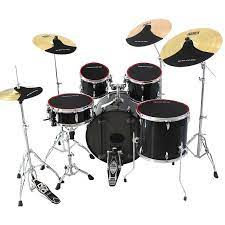

In [10]:
from IPython.display import display, Video, Image


examples_dir = Path("Video-LLaVA/videollava/serve/examples")
video_file = examples_dir / "sample_demo_22.mp4"
image_file = examples_dir / "sample_img_22.png"


video_tensor = video_processor.preprocess(str(video_file), return_tensors="pt")["pixel_values"][0]
image_tensor = image_processor.preprocess(str(image_file), return_tensors="pt")["pixel_values"][0]
images_tensor = [video_tensor, image_tensor]

text_message = "Are the instruments in the pictures used in the video?"
print(f"Question: {text_message}")
display(Video(video_file, embed=True))
Image(image_file, embed=True)

### Test model inference
[back to top ⬆️](#Table-of-contents:)

Generation process for long response maybe time consuming, for accessing partial result as soon as it is generated without waiting when whole process finished, Streaming API can be used. Token streaming is the mode in which the generative system returns the tokens one by one as the model generates them. This enables showing progressive generations to the user rather than waiting for the whole generation. Streaming is an essential aspect of the end-user experience as it reduces latency, one of the most critical aspects of a smooth experience. You can find more details about how streaming work in [HuggingFace documentation](https://huggingface.co/docs/text-generation-inference/conceptual/streaming).

Also for simplification of preparing input in conversational mode, we will use Conversation Template helper provided by model authors for accumulating history of provided messages and images.

In [11]:
from videollava.mm_utils import tokenizer_image_token, KeywordsStoppingCriteria
from videollava.constants import IMAGE_TOKEN_INDEX
from transformers import TextStreamer
from videollava.conversation import conv_templates, SeparatorStyle

# Prepare
streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)
conv_mode = "llava_v1"

conv = conv_templates[conv_mode].copy()
roles = ("user", "assistant")

if mm_use_im_start_end:
    inp = DEFAULT_VIDEO_START_TOKEN + DEFAULT_IMAGE_TOKEN * 8 + DEFAULT_VIDEO_END_TOKEN + "\n" + text_message
else:
    inp = DEFAULT_IMAGE_TOKEN * 8 + "\n" + text_message
conv.append_message(conv.roles[0], inp)
conv.append_message(conv.roles[1], None)

prompt = conv.get_prompt()
input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt").unsqueeze(0)


stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
keywords = [stop_str]
stopping_criteria = KeywordsStoppingCriteria(keywords, tokenizer, input_ids)
streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)
print("Answer:")

output_ids = ov_model.generate(
    input_ids,
    images=images_tensor,
    do_sample=True,
    temperature=0.2,
    max_new_tokens=1024,
    streamer=streamer,
    use_cache=True,
    stopping_criteria=[stopping_criteria],
)

Answer:
['video', 'image']
Yes, the instruments in the pictures are used in the video. The man is playing a drum set, which includes a bass drum, snare drum, and cymbals. The cymbals are used to produce different sounds, such as crashes and hi-hats. The man is also seen playing a guitar, which is another instrument used in the video.


## Interactive demo
[back to top ⬆️](#Table-of-contents:)


In [12]:
import torch
import gradio as gr

from videollava.constants import DEFAULT_IMAGE_TOKEN, IMAGE_TOKEN_INDEX
from videollava.conversation import conv_templates, SeparatorStyle


def generate(image, video, textbox_in):
    if video is not None:
        textbox_in = DEFAULT_IMAGE_TOKEN * 8 + "\n" + textbox_in
        if image is not None:
            textbox_in += "\n" + DEFAULT_IMAGE_TOKEN
    elif image is not None:
        textbox_in = DEFAULT_IMAGE_TOKEN + "\n" + textbox_in

    conv_mode = "llava_v1"
    conv = conv_templates[conv_mode].copy()
    conv.append_message(conv.roles[0], textbox_in)
    conv.append_message(conv.roles[1], None)
    prompt = conv.get_prompt()
    images_tensor = []
    if image is not None:
        images_tensor.append(image_processor(image, return_tensors="pt")["pixel_values"][0])
    if video is not None:
        images_tensor.append(video_processor(video, return_tensors="pt")["pixel_values"][0])
    input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt").unsqueeze(0)

    stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
    keywords = [stop_str]
    stopping_criteria = KeywordsStoppingCriteria(keywords, tokenizer, input_ids)

    generate_kwargs = dict(
        input_ids=input_ids,
        images=images_tensor,
        max_new_tokens=1024,
        temperature=0.2,
        do_sample=True,
        use_cache=True,
        stopping_criteria=[stopping_criteria],
    )

    output_ids = ov_model.generate(**generate_kwargs)

    input_token_len = input_ids.shape[1]
    outputs = tokenizer.batch_decode(output_ids[:, input_token_len:], skip_special_tokens=True)[0]
    outputs = outputs.strip()
    if outputs.endswith(stop_str):
        outputs = outputs[: -len(stop_str)]
    outputs = outputs.strip()

    return outputs


demo = gr.Interface(
    generate,
    [
        gr.Image(label="Input Image", type="filepath"),
        gr.Video(label="Input Video"),
        gr.Textbox(label="Question"),
    ],
    gr.Textbox(lines=10),
    examples=[
        [
            f"{examples_dir}/extreme_ironing.jpg",
            None,
            "What is unusual about this image?",
        ],
        [
            f"{examples_dir}/waterview.jpg",
            None,
            "What are the things I should be cautious about when I visit here?",
        ],
        [
            f"{examples_dir}/desert.jpg",
            None,
            "If there are factual errors in the questions, point it out; if not, proceed answering the question. What’s happening in the desert?",
        ],
        [
            None,
            f"{examples_dir}/sample_demo_1.mp4",
            "Why is this video funny?",
        ],
        [
            None,
            f"{examples_dir}/sample_demo_3.mp4",
            "Can you identify any safety hazards in this video?",
        ],
        [
            None,
            f"{examples_dir}/sample_demo_9.mp4",
            "Describe the video.",
        ],
        [
            None,
            f"{examples_dir}/sample_demo_22.mp4",
            "Describe the activity in the video.",
        ],
        [
            f"{examples_dir}/sample_img_22.png",
            f"{examples_dir}/sample_demo_22.mp4",
            "Are the instruments in the pictures used in the video?",
        ],
        [
            f"{examples_dir}/sample_img_13.png",
            f"{examples_dir}/sample_demo_13.mp4",
            "Does the flag in the image appear in the video?",
        ],
        [
            f"{examples_dir}/sample_img_8.png",
            f"{examples_dir}/sample_demo_8.mp4",
            "Are the image and the video depicting the same place?",
        ],
    ],
    title="Video-LLaVA🚀",
    allow_flagging="never",
)
try:
    demo.queue().launch(debug=True)
except Exception:
    demo.queue().launch(share=True, debug=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/